In [2]:
import requests
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
from sphere import Sphere as S
import seaborn as sns
import os

sns.set_theme()
sns.set_style("whitegrid")
sns.set_context(
    "paper", rc={"axes.legendsize": 20, "axes.labelsize": 20, "axes.xtickssize": 20}
)

In [4]:
def load_data():

    # https://opendatadocs.dmi.govcloud.dk/Data/Climate_Data_Stations
    api_key = "1c818f3c-6b69-4ea9-bca3-0e47fdf44494"
    url = "https://dmigw.govcloud.dk/v2/metObs/collections/observation/items"
    params = {
        "parameterId": "wind_dir",
        "stationId": "06081",
        "datetime": "2020-11-01T00:00:00Z/2024-11-07T23:59:59Z",
        "api-key": api_key,
    }

    def get_next(links):
        for link in links:
            if link["rel"] == "next":
                return link["href"]
        return None

    response = requests.get(url, params=params)

    collected_features = []

    for i in range(100):
        data = response.json()
        collected_features.extend(data["features"])

        next_url = get_next(data["links"])
        if next_url:
            print("Getting next page", next_url)
            response = requests.get(next_url)
        else:
            break

    df = pd.DataFrame(map(lambda x: x["properties"], collected_features))
    df["timestamp"] = pd.to_datetime(df["created"])

    df["angle"] = df["value"] / 360 * 2 * np.pi
    df["x"] = np.cos(df["angle"])
    df["y"] = np.sin(df["angle"])

    df.to_csv("wind_dir.csv")
    return df


if os.path.exists("wind_dir.csv"):
    df = pd.read_csv("wind_dir.csv")
    df["timestamp"] = pd.to_datetime(df["timestamp"])
else:
    df = load_data()

midday_df = (
    df[df["timestamp"].dt.hour == 12].groupby(df["timestamp"].dt.floor("h")).first()
)

In [5]:
midday_df = (
    df[
        (df["timestamp"].dt.hour == 12)
        & (df["timestamp"].dt.year == 2024)
        & (df["timestamp"].dt.month >= 6)
        & (df["timestamp"].dt.month < 11)
    ]
    .groupby(df["timestamp"].dt.floor("h"))
    .first()
)

[-0.6949047 -0.7191017]


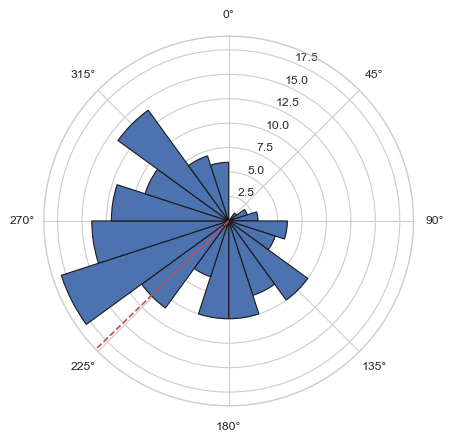

In [6]:
X = jnp.array(midday_df[["x", "y"]].values)
mu_hat = S.frechet_mean(X, None, max_iter=100)
print(mu_hat)
mu_hat_angle = np.arctan2(mu_hat[1], mu_hat[0]) + 2 * np.pi
data = 2 * np.pi * midday_df["value"].values / 360
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
num_bins = 20  # Number of bins for the histogram
theta_bins = np.linspace(0, 2 * np.pi, num_bins + 1)
counts, _ = np.histogram(data, bins=theta_bins)
bars = ax.bar(
    theta_bins[:-1], counts, width=(2 * np.pi) / num_bins, align="edge", edgecolor="k"
)
ax.axvline(mu_hat_angle, color="r", linestyle="--")
ax.set_theta_zero_location("N")  # 0 at the top (North)
ax.set_theta_direction(-1)  # Clockwise direction

plt.show()

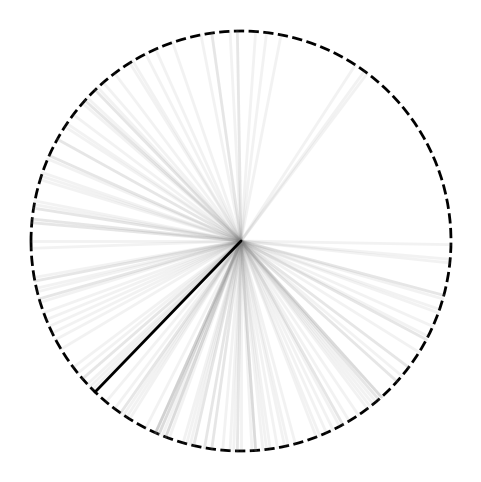

In [7]:
theta = np.linspace(-np.pi, np.pi, 300)
counts, _ = np.histogram(data, bins=theta)

density = counts / counts.sum() * 20

circle_x = np.cos(theta)
circle_y = np.sin(theta)

fig, ax = plt.subplots(figsize=(6, 6))
plt.grid(False)
plt.plot(circle_x, circle_y, "--", linewidth=2, color="black", zorder=0)

x = 2 * np.pi * midday_df["value"].values / 360
x = jnp.array([np.cos(x), np.sin(x)]).T

mu_hat = S.frechet_mean(x, None, max_iter=100)
mu_0 = jnp.array([np.cos(5 * np.pi / 4), np.sin(5 * np.pi / 4)])

for i in range(x.shape[0]):
    plt.plot([0, x[i, 0]], [0, x[i, 1]], color="grey", zorder=1, alpha=0.1, linewidth=2)

plt.plot([0, mu_hat[0]], [0, mu_hat[1]], color="black", zorder=1, linewidth=2)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
plt.xticks([])
plt.yticks([])
ax.set_aspect("equal")
plt.savefig(
    "./plots/wind_data.pdf",
    bbox_inches="tight",
    transparent=True,
)

p-value =  0.6410000324249268
1.7425898


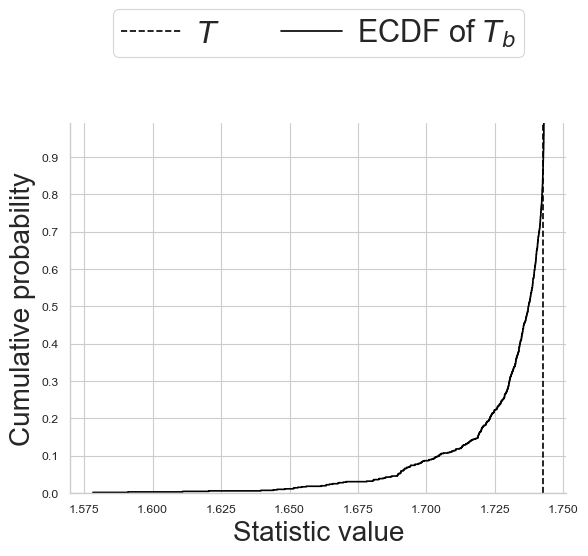

In [8]:
from manifold import mirror_vecs, dist_sq_arr


def mixture(key, x0, x1, p):
    num_dims = len(x0.shape) - 1
    shape = (x0.shape[0], *[1 for _ in range(num_dims)])
    z = jax.random.choice(
        key, jnp.array([0.0, 1.0]), shape=shape, p=jnp.array([p, 1 - p])
    )
    return z * x0 + (1.0 - z) * x1


num_bootstrap = 1000


def proc_inner(M, x, mu_0, key):
    fm_key, key = jax.random.split(key, 2)
    x_mirrored = mirror_vecs(M, mu_0, x)

    mu_hat = M.frechet_mean(x, fm_key)
    t = dist_sq_arr(M, mu_hat, x).mean()

    def fun(it_key):
        z_key, fm_key = jax.random.split(it_key)
        x_b = mixture(z_key, x, x_mirrored, 1 / 2)
        mu_hat_b = M.frechet_mean(x_b, fm_key)
        return dist_sq_arr(M, mu_hat_b, x_b).mean()

    t_b = jax.vmap(fun)(jax.random.split(key, num_bootstrap))

    return t, t_b


mu_0_angle = 5 * np.pi / 4
key = jax.random.PRNGKey(0)
t, t_b = proc_inner(
    S,
    X,
    jnp.array([np.cos(mu_0_angle), np.sin(mu_0_angle)]),
    key,
)
print("p-value = ", (t_b <= t).mean().item())

plt.axvline(t, linestyle="--", color="black", label=r"$T$")
plt.ecdf(t_b[~np.isnan(t_b)], color="black", label=r"ECDF of $T_b$")
plt.xlabel("Statistic value")
plt.ylabel("Cumulative probability")
plt.grid("on")
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.35),
    ncol=2,
    handlelength=2.0,
    handletextpad=0.5,
    prop={"size": 22},
    borderpad=0.25,
)
plt.yticks(np.linspace(0, 1, 11))
plt.ylim(0, 0.99)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

print(t)

plt.savefig(
    "./plots/wind_result.pdf",
    bbox_inches="tight",
    transparent=True,
)

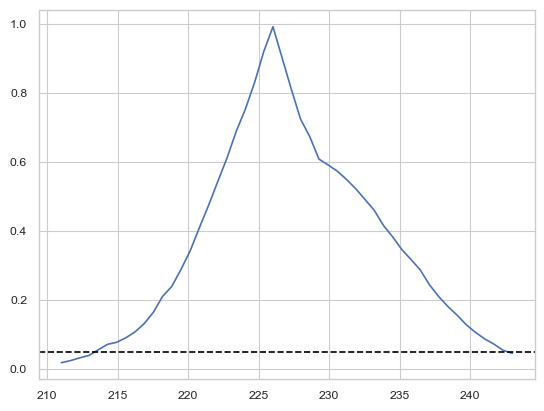

In [58]:
mu_delta_angles = np.linspace(211, 243, 50)
results = np.zeros_like(mu_delta_angles)

for i, mu_delta_angle in enumerate(mu_delta_angles):
    _angle = mu_delta_angle / 360 * 2 * np.pi
    key = jax.random.PRNGKey(0)
    t, t_b = proc_inner(
        S,
        X,
        jnp.array([np.cos(_angle), np.sin(_angle)]),
        key,
    )
    results[i] = (t_b <= t).mean().item()

plt.plot(mu_delta_angles, results)
plt.axhline(0.05, linestyle="--", color="black")

In [59]:
np.c_[
    mu_delta_angles, results, results >= 0.05
]  # [214, 242] is the confidence interval

array([[2.11000000e+02, 1.80000011e-02, 0.00000000e+00],
       [2.11653061e+02, 2.40000002e-02, 0.00000000e+00],
       [2.12306122e+02, 3.20000015e-02, 0.00000000e+00],
       [2.12959184e+02, 3.90000008e-02, 0.00000000e+00],
       [2.13612245e+02, 5.50000034e-02, 1.00000000e+00],
       [2.14265306e+02, 7.10000023e-02, 1.00000000e+00],
       [2.14918367e+02, 7.70000070e-02, 1.00000000e+00],
       [2.15571429e+02, 9.00000036e-02, 1.00000000e+00],
       [2.16224490e+02, 1.07000008e-01, 1.00000000e+00],
       [2.16877551e+02, 1.31000012e-01, 1.00000000e+00],
       [2.17530612e+02, 1.64000005e-01, 1.00000000e+00],
       [2.18183673e+02, 2.10000008e-01, 1.00000000e+00],
       [2.18836735e+02, 2.39000008e-01, 1.00000000e+00],
       [2.19489796e+02, 2.88000017e-01, 1.00000000e+00],
       [2.20142857e+02, 3.42000008e-01, 1.00000000e+00],
       [2.20795918e+02, 4.09000009e-01, 1.00000000e+00],
       [2.21448980e+02, 4.74000037e-01, 1.00000000e+00],
       [2.22102041e+02, 5.43000

In [37]:
theta

(152,)

In [43]:
pd.DataFrame({"angle": theta}).to_csv("wind_angles.csv")

Array(-25.072367, dtype=float32)

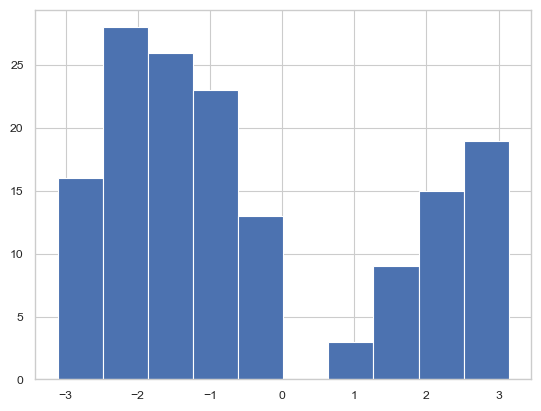

In [45]:
alpha = 0
rot = jnp.array([[np.cos(alpha), -np.sin(alpha)], [np.sin(alpha), np.cos(alpha)]])

theta = jnp.atan2((rot @ X.T)[1, :], (rot @ X.T)[0, :])

plt.hist(theta)
(theta.mean()) / np.pi * 180

In [35]:
def watson_mean_angle_test(angles, mu_0=0.0):
    from scipy.stats import chi2

    n = len(angles)
    c_bar = np.mean(np.cos(angles))
    s_bar = np.mean(np.sin(angles))
    R = np.sqrt(c_bar**2 + s_bar**2)
    mean_angle = np.arctan2(s_bar, c_bar)
    T = 2 * n * (R**2) * (1 - np.cos(mean_angle - mu_0))
    p_value = 1 - chi2.cdf(T, df=1)
    return T, p_value, mean_angle, R


T, p_value, mean_angle, R = watson_mean_angle_test(theta, mu_0_angle)
print(T, p_value, mean_angle, R)

print(mu_0_angle / np.pi * 180)
print(mean_angle / np.pi * 180)

64.61350494338166 8.881784197001252e-16 1.792293 0.3721715284574131
225.0
102.69082183144202


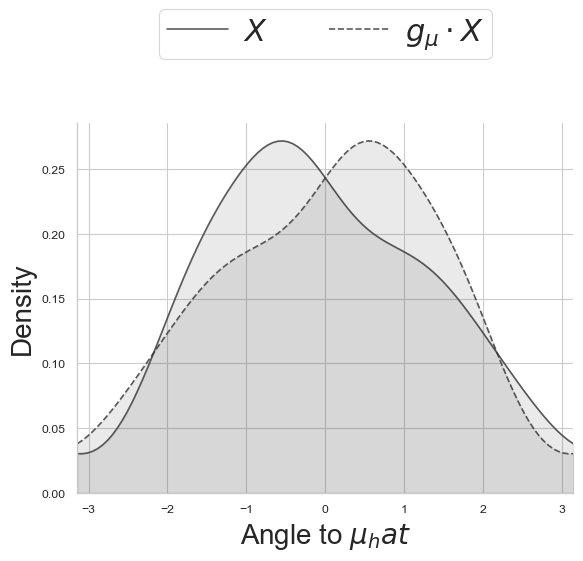

In [ ]:
from scipy import stats


def circular_kde(angles, n_points=100):
    extended_data = np.concatenate([angles - 2 * np.pi, angles, angles + 2 * np.pi])
    kde = stats.gaussian_kde(extended_data, bw_method=0.1)

    # Evaluate only on the [-π, π] range
    x = np.linspace(-np.pi, np.pi, n_points)
    density = kde(x)

    # Adjust for the replicated data by adding densities at wrap points
    density += kde(x - 2 * np.pi) + kde(x + 2 * np.pi)
    return x, density


x_mirrored = mirror_vecs(S, mu_hat, X)

angles_original = jnp.arctan2(jnp.cross(X, mu_0), jnp.dot(X, mu_0))
angles_mirrored = jnp.arctan2(jnp.cross(x_mirrored, mu_0), jnp.dot(x_mirrored, mu_0))

x1, y1 = circular_kde(angles_original)
x2, y2 = circular_kde(angles_mirrored)

plt.plot(x1, y1, color="#333333", linestyle="-", label=r"$X$", alpha=0.8)
plt.fill_between(x1, y1, color="#333333", alpha=0.1)
plt.plot(x2, y2, color="#333333", linestyle="--", label=r"$g_\mu \cdot X$", alpha=0.8)
plt.fill_between(x2, y2, color="#333333", alpha=0.1)

plt.xlim(-np.pi, np.pi)
plt.ylim(0)
plt.xlabel(r"Angle to $\mu_0$")
plt.ylabel("Density")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.35),
    ncol=2,
    handlelength=2.0,
    handletextpad=0.5,
    prop={"size": 22},
    borderpad=0.25,
)

plt.savefig(
    "./plots/wind_sym.pdf",
    bbox_inches="tight",
    transparent=True,
)